In [1]:
#Imports and utils
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from numpy import zeros, ones 
import numpy as np
from numpy.random import randn, randint
import tensorflow as tf
from matplotlib import pyplot as plt
from model.dcgan_cifar import discriminator_, generator_, dcgan_
from utils.dataset_utils import return_cifar10 
from utils.model_utils import true_samples_generator, fake_samples_generator, make_latent_samples
from utils.visualizers_utils import show_generated_images, performance_summarizer
from tqdm.notebook import tqdm
from utils.visualizers_utils import show_gan_losses
import imageio
from glob import glob
import re
from utils.visualizers_utils import generate_video 
from utils.image_utils import preprocess_image, scaleback_image, image_loader

In [46]:
#Load the discriminator model trained on SVHN dataset
model = tf.keras.models.load_model("trained_models/DCGAN_SVHN_NOBN/discriminator/")

In [47]:
# Save the names of layers in this model to a list and display
layer_names = [layer.name for layer in model.layers]
layer_names

['conv2d',
 'leaky_re_lu',
 'conv2d_1',
 'leaky_re_lu_1',
 'conv2d_2',
 'leaky_re_lu_2',
 'conv2d_3',
 'leaky_re_lu_3',
 'flatten',
 'dropout',
 'dense']

In [48]:
# Save the output shape of each layers in this model to a list and display 
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<tf.Tensor 'conv2d/Identity:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'leaky_re_lu/Identity:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'conv2d_1/Identity:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'leaky_re_lu_1/Identity:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'conv2d_2/Identity:0' shape=(None, 8, 8, 128) dtype=float32>,
 <tf.Tensor 'leaky_re_lu_2/Identity:0' shape=(None, 8, 8, 128) dtype=float32>,
 <tf.Tensor 'conv2d_3/Identity:0' shape=(None, 4, 4, 256) dtype=float32>,
 <tf.Tensor 'leaky_re_lu_3/Identity:0' shape=(None, 4, 4, 256) dtype=float32>,
 <tf.Tensor 'flatten/Identity:0' shape=(None, 4096) dtype=float32>,
 <tf.Tensor 'dropout/Identity:0' shape=(None, 4096) dtype=float32>,
 <tf.Tensor 'dense/Identity:0' shape=(None, 1) dtype=float32>]

In [54]:
import scipy.io
data = scipy.io.loadmat('data/shvn/train.mat')['X']
data = np.rollaxis(data, 3) 


print(data.min(), data.max())

0 255


In [125]:
# Defined functions for visulizing filters
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
#     img = keras.preprocessing.image.load_img(img_path)
    img = img_array

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    # plt.figure(dpi=300)
    fig, ax = plt.subplots(1, 2, dpi=100)
    # ax1.plot(x, y)
    # ax2.plot(x, -y)
    
    ax[1].imshow(superimposed_img)
    ax[0].set_title("Input image")
    ax[0].imshow(img_array)
    ax[1].set_title("Gradcam result")
    for ax_ in ax:
        ax_.set_xticks([])
        ax_.set_yticks([])

    return superimposed_img

def grad_cam_main(img_array, model, name=None, conv_name="conv2d_3"):
    pred = model.predict(np.reshape(img_array, (-1, 32, 32, 3)))
    heatmap = make_gradcam_heatmap(np.reshape(img_array, (-1, 32, 32, 3)), model, last_conv_layer_name=conv_name)

    superimposed_img = save_and_display_gradcam(img_array, heatmap)
    plt.savefig("results/gradcam_results/40epochs_"+str(name)+".png")
    plt.show()

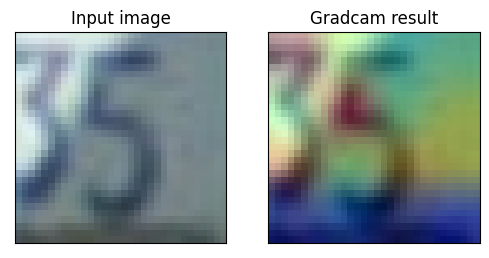

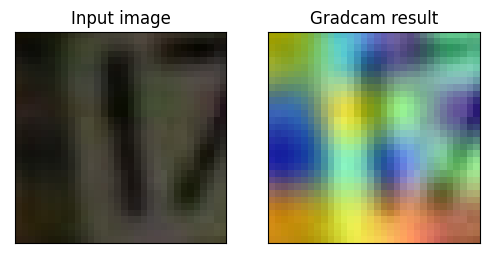

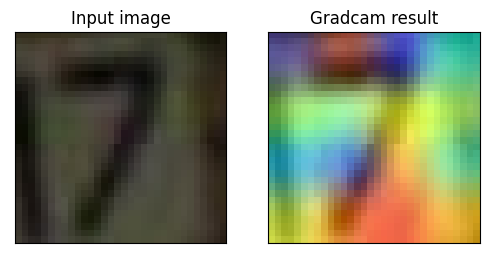

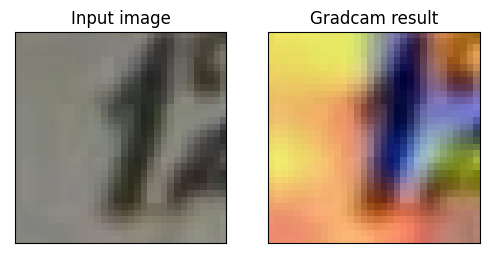

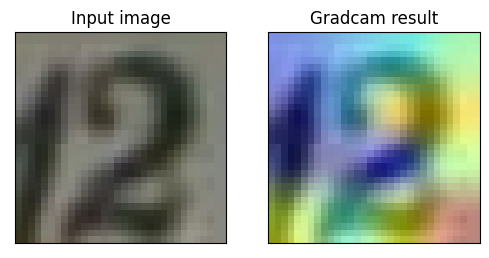

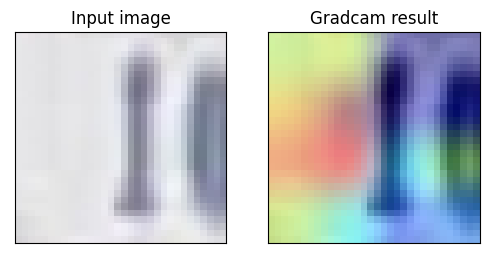

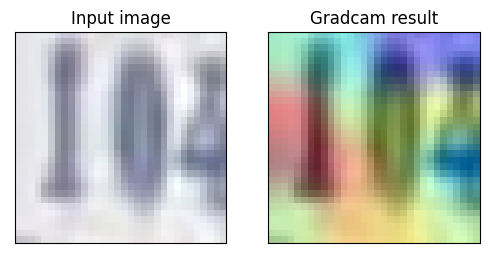

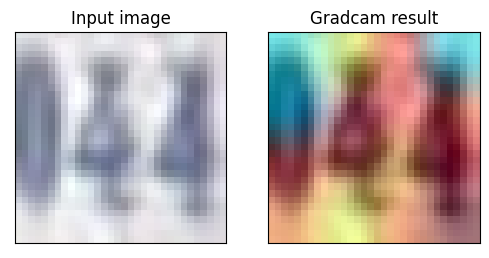

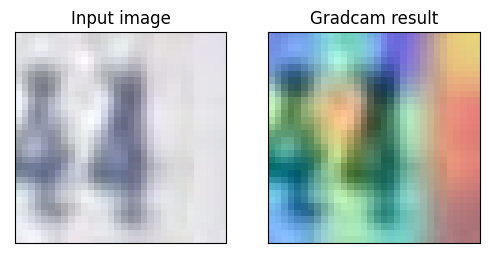

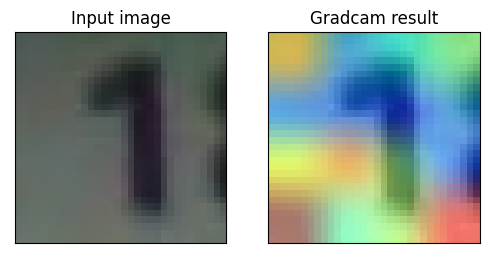

In [126]:
model = tf.keras.models.load_model("trained_models/DCGAN_SVHN_NOBN_40Epochs/discriminator/") 
# model.summary()
model.layers[-1].activation = None 

# Visualizing filters on 10 images from SVHN dataset
for i, img_array in enumerate(data[200:210]):
    
    grad_cam_main(img_array, model, i, "conv2d_18")